# Flat Fielding of Slitless Spectroscopy

### Participants: Kornpob Bhirombhakdi, [Russell Ryan](mailto:rryan@stsci.edu), and [Mehdi Rezaie](mailto:mr095415@ohio.edu)
### Astrogrism-27 Goal
***The goal of this ticket is to assess what it might take to migrate away from aXe for this step of grism data processing (flat fielding).  This notebook has benefited significantly from Astrogrism-53.***


## 0.  Primer
Slitless spectroscopy uses a dispersive and transmissive optical element in the collimated beam to create a complete spectroscopic view of any astrophysical scene.  However, the lack of any light-restricting aperture (such as a slitlet, fiber, etc.), means that the spectral trace of multiple sources may overlap in the two-dimensional grism image.  Therefore a given imaging pixel may record the flux (at different wavelengths) from the multiple sources and/or background components (such as Zodiacal background, thermal emission, etc.).  Here, we discuss the issues associated with extending the classical application of a flat-field image to correct for pixel-to-pixel variations in the imaging device to that of slitless spectroscopy.


This notebook was prepared by Kornpob Bhirombhakdi, [Russell Ryan](mailto:rryan@stsci.edu), and [Mehdi Rezaie](mailto:mr095415@ohio.edu) as part of the Astrogrism coding spring May 11-16, 2020.  

## 1.  Review of Key Concepts



optical path of an imaging device may include physical obstructions (e.g. dust or particulates on optimal elements), illumination effects (e.g. vignetting), and/or variable pixel-to-pixel sensitivities, which leads to a nonuniform response. 


Since the sensitivity of a given pixel depends on the wavelength of incident light, the flat-field response must be characterized as a (${\cal F}(\lambda)$), and therefore the measured response in a given pixel $(x,y)$ is given as an integral:
$$
r_{x,y}  = \int {\cal F}_{x,y}(\lambda)\, f_{x,y}(\lambda)\,\mathrm{d}\lambda
\tag{1}
$$
where $f(\lambda)$ is the spectrum of the incident light.  





## 2.  Extensions to Slitless Spectroscopy

One key difference between a grism optical element and a standard imaging element is that light incident on a given pixel $(x_d,y_d)$ will be recorded a new pixel position $(x_g,y_g)$, where that remapping is done as a function of wavelength and $(x_d,y_d)$.  This process must be calibrated by standard observations, which often results in determining the spectral trace and dispersion solution.  Software has been developed by [Nor Prizkal and Russell Ryan](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2017/WFC3-2017-01.pdf) to implement these transformations, and are represented a parametric functions:


$$
x_g = \mathrm{X} (x_d,y_d,t) + x_d\\
y_g = \mathrm{Y} (x_d,y_d,t) + y_d\\
\lambda = \Lambda (x_d,y_d,t)
\tag{2}
$$

where $t$ is a parameter such that $0\leq t\leq1$.  With that, it is apparent that the response of a pixel (eq. 1) must be reconsidered as the incident spectrum effectively eminates from a different position:
$$
r_{x_g,y_g} = \int {\cal F}_{x_g,y_g}(\lambda)\,f_{x_d,y_d}(\lambda)\,\mathrm{d}\lambda.
\tag{3}
$$
***Note, here we take care to explicitly subscript $(x,y)$ with either $g$ or $d$ to refer to the measured position in a grism image or effective position from a direct image, respectively.***  Therefore, when flat-fielding one must invert the family of functions for $(x_g,y_g,\lambda)$ to account for the relevant spectral components (whether from astrophysical sources or background contributions).  



The flat-field image for slitless spectroscopy is often characterized as a polynomial in wavelength, where each of the polynomial coefficients is a two-dimensional image:
$$
{\cal F}_{x,y}(\lambda) = \sum_i {\cal F}_{x,y,i}\left(\frac{\lambda-\lambda_0}{\lambda_1-\lambda_0}\right)^i 
\tag{4}
$$
where $\lambda_0$ and $\lambda_1$ are arbitrary values that are often choosen to be approximately the blue and red edges (respectively) of the throughput of the grism element. In common usage, this is often referred to as a *flatfield cube*.  

Here is a schematic image of a flat field cube. 

![flat field](figures/flatfieldcube.png)

This notebook illustrates the implementation of a simple flat fielding. To run this notebook, you need the following modules set up:
1. astropy (https://www.astropy.org)
2. numpy (https://numpy.org)
3. gwcs (https://gwcs.readthedocs.io/en/latest/)
4. scipy
5. axehelper
6. polynomial2d

This notebook takes advantage of two self contained modules from pyLinear (Russell Ryan) and axehelper, Polynomial2D (Kornpob Bhiromhakdi)

## 3.  Simplifying Examples



### 3.1 Local ACS WFC data

KP: how about we use WFC3/IR data?

This example will use the data from ACS_WFC_GRISM directory

Steps

1. read an Axe Config file with `AXEhelper_ConfReader`
2. use `AXEhelper_computeSIP` to get the 1D coefficients from the [WFC3 report](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2016/WFC3-2016-15.pdf).
3. use `AXEhelper_computeTraceNWavelength` to get the wavelength $\lambda$
4. use `AXEhelper_FlatField` to get the flat field image

Next steps

5. Debug, add logger and documentation
6. Implement transformation with GWCS
7. Test with a dataset
8. Comparison with other flat field models

Implementation

In [1]:
import os
import sys

import numpy as np

from astropy.io import fits

%matplotlib inline
import matplotlib.pyplot as plt

sys.path.insert(0, '../')
import src

In [2]:
class FlatField:
    """
    Wrapper around KP's axehelper and polynomial2D modules
    
    methods
    ----------
    self.run
    self.get_wavelength,
        
        
    self.get_flatfield
    
    
    """
    def __init__(self, 
                 flat_file, 
                 conf_file):
        
        self.flat_file = flat_file
        self.conf_file = conf_file
        
    def run(self, 
            xref=np.array([400.]), 
            yref=np.array([500.])):
        
        wavelength = self.get_wavelength(self.flat_file,
                                        self.conf_file, 
                                        xref, 
                                        yref)
        
        flatfield = self.get_flatfield(self.flat_file,
                                       wavelength)
        
        self.output = {
            'wavelength':wavelength, 
            'flatfield':src.array(flatfield), # array obj will give imshow functionality 
            'ref':(xref, yref),
            'flat_file':self.flat_file, 
            'conf_file':self.conf_file
        }
        
    
    def get_wavelength(self, 
                       flat_file, 
                       conf_file, 
                       xref, 
                       yref):
        
        # read flat field and read nax1 and nax2
        tmp = fits.open(flat_file)
        nax1, nax2 = tmp[0].header['NAXIS1'], tmp[0].header['NAXIS2']
        
        # read config file and get the coeffcients
        conf = src.AXEhelper_ConfReader(conf_file)
        conf.getbeam()
        conf.make_coef2d()
        
        # given ref coordinates, compute SIP
        obj = src.AXEhelper_computeSIP(conf.coef2d, xref, yref)
        obj.compress()
        
        newobj = src.AXEhelper_computeTraceNWavelength(obj.coef1d,
                                                   obj.x1,
                                                   obj.x2,
                                                   nax1, nax2)
        newobj.compute()
        return newobj.wavelength['WW']
        
    def get_flatfield(self, 
                      flat_file, 
                      wavelength):
        
        flat = src.AXEhelper_FlatField(flat_file, wavelength)
        flat.compute()
        return flat.flatfield

read config file and flat field cube file

In [3]:
'''
    FlatField takes the paths to flat field cube and config file

    It also takes a set of reference coordinates
'''

conf_file = '../inputs/aXe_config/ACS.WFC.CHIP1.Cycle13.5.conf'
flat_file = '../inputs/ACS_WFC_Grism_Data/save/CONF/WFC.flat.cube.CH1.2.fits'


xref = np.array([400.]) # KP: assume source location 
yref = np.array([500.]) # (with other calibration) leading xref,yref

ff = FlatField(flat_file, conf_file)
ff.run(xref, yref)

The `output` will have wavelength, flatfield image, reference points, and the paths to input files.

In [4]:
ff.output

{'wavelength': array([ -9860.08019665,  -9824.7972306 ,  -9789.50790395, ...,
        187818.60157911, 187879.91851473, 187941.24181096]),
 'flatfield': array([[1.0387969 , 1.03876734, 1.03873777, ..., 0.93043095, 0.93040717,
         0.93038356],
        [1.03882861, 0.99843651, 0.98882228, ..., 0.93045634, 0.93043256,
         0.93040895],
        [1.0388602 , 1.00296319, 0.99715602, ..., 0.93048179, 0.93045807,
         0.93043447],
        ...,
        [1.10786474, 1.10783124, 1.1077975 , ..., 0.98545861, 0.98543197,
         0.98540545],
        [1.10790074, 1.10786724, 1.1078335 , ..., 0.9854871 , 0.98546046,
         0.98543394],
        [1.10793686, 1.10790324, 1.10786963, ..., 0.98551559, 0.98548895,
         0.98546243]]),
 'ref': (array([400.]), array([500.])),
 'flat_file': '../inputs/ACS_WFC_Grism_Data/save/CONF/WFC.flat.cube.CH1.2.fits',
 'conf_file': '../inputs/aXe_config/ACS.WFC.CHIP1.Cycle13.5.conf'}

In [5]:
flatfield = ff.output['flatfield']

In [6]:
flatfield # is a numpy array but also has the imshow functionality

array([[1.0387969 , 1.03876734, 1.03873777, ..., 0.93043095, 0.93040717,
        0.93038356],
       [1.03882861, 0.99843651, 0.98882228, ..., 0.93045634, 0.93043256,
        0.93040895],
       [1.0388602 , 1.00296319, 0.99715602, ..., 0.93048179, 0.93045807,
        0.93043447],
       ...,
       [1.10786474, 1.10783124, 1.1077975 , ..., 0.98545861, 0.98543197,
        0.98540545],
       [1.10790074, 1.10786724, 1.1078335 , ..., 0.9854871 , 0.98546046,
        0.98543394],
       [1.10793686, 1.10790324, 1.10786963, ..., 0.98551559, 0.98548895,
        0.98546243]])

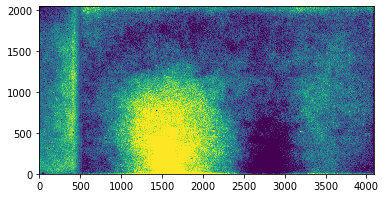

In [7]:
flatfield.imshow(origin='lower', cmap='viridis', hold=True)
plt.savefig('figures/flatfield.png')

### 3.2 CRDS (incomplete)

This example will use `crds` to access a reference file, find the offset between flat field image and science image.

In [8]:
# read data 
data = src.DataLoader('../inputs/icoi3immq_flt.fits')

Filename: ../inputs/icoi3immq_flt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     270   ()      
  1  SCI           1 ImageHDU       195   (1014, 1014)   float64   
  2  ERR           1 ImageHDU        51   (1014, 1014)   float32   
  3  DQ            1 ImageHDU        43   (1014, 1014)   int16   
  4  SAMP          1 ImageHDU        37   (1014, 1014)   int16   
  5  TIME          1 ImageHDU        37   (1014, 1014)   float32   


In [9]:
''' let's get the reference file from the 0th extension
    OSCNTAB will point us at the reference file
'''
reference_file = data.get_keyword('OSCNTAB', ext=0)
reference_file = reference_file.split('$')[-1]
print(f'ref file: {reference_file}')

ref file: q911321mi_osc.fits


In [10]:
''' Download the ref file if it does not exist already

    we need to set the CRDS path and make a sytem call!
'''
crds_dir = os.path.join(os.environ["HOME"], "crds_cache")
os.environ["CRDS_PATH"] = crds_dir 
ref_file_path = os.path.join(crds_dir, reference_file)

if not os.path.exists(ref_file_path):
    
    print(f'{ref_file_path} does not exist! downloading ...')
    
    cmd = f'crds bestrefs --files {reference_file}  --sync-references=1  --update-bestrefs'
    error = os.system(cmd)
    
    if error != 0: # MR: I'll have to set up crds on my computer
        print('something went wrong!')

/Users/mehdi/crds_cache/q911321mi_osc.fits does not exist! downloading ...
something went wrong!


Visualize the science image

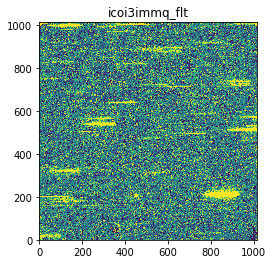

In [11]:
science = data.read_ext(1) # you can read a given extension
science.imshow(title='icoi3immq_flt')

## 4.  Issues and Caveats


